In [2]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = fetch_401K(return_type='DataFrame')
dtypes = data.dtypes
dtypes['nifa'] = 'float64'
dtypes['net_tfa'] = 'float64'
dtypes['tw'] = 'float64'
dtypes['inc'] = 'float64'
data = data.astype(dtypes)
data.head()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1


In [ ]:
# net_tfa: net financial wealth (Y)

# nifa: net income
# e401: 401k eligibility indicator
# p401: 401k participation indicator
# pira: IRA participation indicator
# inc: income
# fsize: family size
# educ: years of education
# db: 
# marr: marrital status
# twoearn: two earner indicator
# hown: home owner indicator


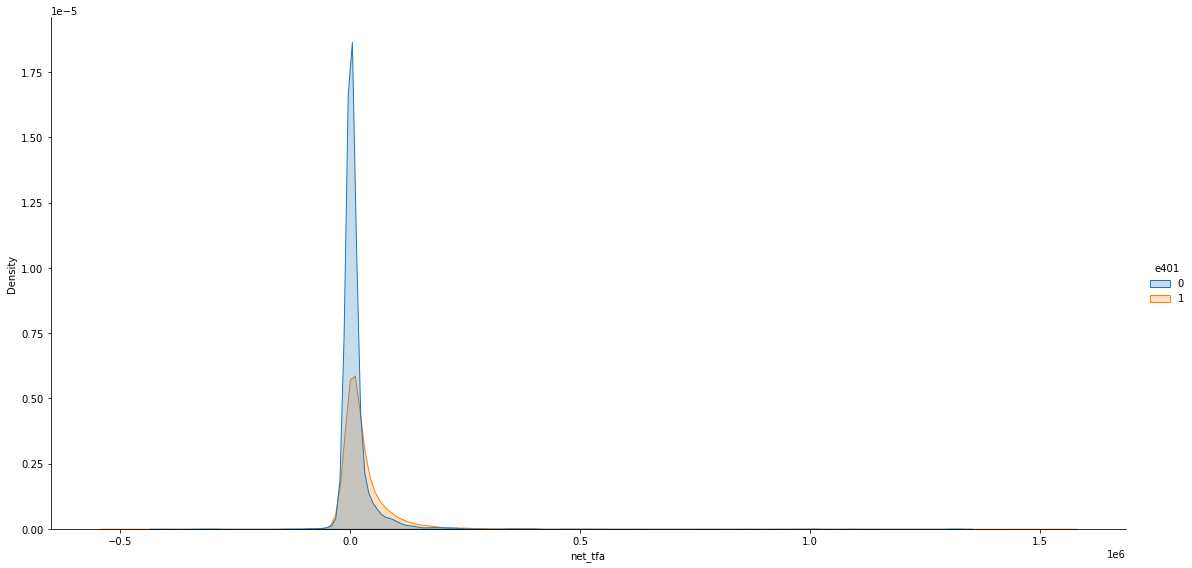

In [15]:
sns.displot(
    data,
    x='net_tfa',
    hue='e401',
    kind='kde',
    fill=True,
    height=8,
    aspect=2,
)

In [17]:
data.groupby('e401')[['net_tfa']].mean()

,net_tfa
e401,
0,10788.044441
1,30347.389191


In [18]:
data.groupby('p401')[['net_tfa']].mean()

,net_tfa
p401,
0,10890.477121
1,38262.060524


## PLR: Partial Linear Regression 

In [25]:
# base linear/lasso to remove X's effect

features_base = ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
data_dml_base = dml.DoubleMLData(
    data,
    y_col = 'net_tfa',
    d_cols = 'e401',
    x_cols = features_base,
)
dml_base = dml.DoubleMLPLR(
    data_dml_base,
    ml_l = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10_000)), # outcome Y
    ml_m = make_pipeline(StandardScaler(), LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', Cs=1e-4*np.logspace(0,4, 10), max_iter=1000)), # treatment D
    n_folds = 3,
)
dml_base.fit(
    store_predictions=True,
)
dml_base.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,5635.792044,1349.771564,4.175367,0.00003,2990.288392,8281.295697


In [26]:
# Decision Tree to remove effect of X

dml_decision_tree = dml.DoubleMLPLR(
    data_dml_base,
    ml_l = DecisionTreeRegressor(max_depth=30, ccp_alpha=0.0046, min_samples_split=203, min_samples_leaf=67),
    ml_m = DecisionTreeClassifier(max_depth=30, ccp_alpha=0.0046, min_samples_split=104, min_samples_leaf=34),
)
dml_decision_tree.fit(store_predictions=True)
dml_decision_tree.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8613.72841,1295.569099,6.648606,2.958820e-11,6074.459637,11152.997183


In [27]:
# Boosted Tree

dml_boosted_tree = dml.DoubleMLPLR(
    data_dml_base,
    ml_l = XGBRegressor(n_jobs=-1, objective='reg:squarederror', eta=0.1, n_estimators=35),
    ml_m = XGBClassifier(use_label_encoder=False, n_jobs=-1, objective='binary:logistic', eval_metric='logloss', eta=0.1, n_estimators=35)
)
dml_boosted_tree.fit(store_predictions=True)
dml_boosted_tree.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,9295.603202,1376.565512,6.75275,1.450685e-11,6597.584376,11993.622028


In [28]:
plr_summary = pd.concat(
    [dml_base.summary, dml_decision_tree.summary, dml_boosted_tree.summary],
)
plr_summary.index = ['lasso', 'decision tree', 'xgboost']
plr_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
lasso,5635.792044,1349.771564,4.175367,2.975056e-05,2990.288392,8281.295697
decision tree,8613.728410,1295.569099,6.648606,2.958820e-11,6074.459637,11152.997183
xgboost,9295.603202,1376.565512,6.752750,1.450685e-11,6597.584376,11993.622028


<ErrorbarContainer object of 3 artists>

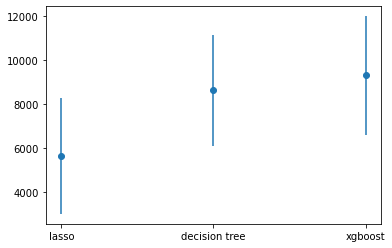

In [30]:
errors = np.full(shape=(2, plr_summary.shape[0]), fill_value=np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']

plt.errorbar(
    plr_summary.index,
    plr_summary.coef,
    fmt='o',
    yerr=errors,
)

## IRM: Interactive Regression model 